In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
# tf.enable_eager_execution()

from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns


Data Extraction

In [53]:
training_data = pd.read_csv("Datasets/train.csv")
test_data = pd.read_csv("Datasets/test.csv")

Data Pre-processing:

One of the first things I like to do is run a pair plot on the various features in the data

In [54]:
# sns.pairplot(training_data)

In [55]:
#Lets now deal with missing data. If there is missing data, we need a strategy
#that will either rid the missing data or determine how to fill the data
columns = list(training_data.columns)
missing_training_data = {}
for col in columns:
    missing_training_data[col] = training_data[col].isna().sum()
missing_training_data

{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [56]:
#Will now do the same as above but for the test data
columns = list(test_data.columns)
missing_test_data = {}
for col in columns:
    missing_test_data[col] = test_data[col].isna().sum()
missing_test_data

{'PassengerId': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 86,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 1,
 'Cabin': 327,
 'Embarked': 0}

Age and Cabin seem to be the main culprits that will cause problems down the road. 
Since a very large majority of the cabin data is missing (~77%), I am going to drop this data
For the age criteria, I am going to assign the average age, but conditioned on class and sex
This will produce a more relfective average rather than simply averaging across the entire age column

In [57]:
#Lets get the average based grouped by sex and pclass
averages = training_data.groupby(by = ["Pclass", "Sex"]).mean()['Age']
averages

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [58]:
#I will now set the missing age data to the correct value based on its condition of class and sex
#I also create a copy of the data set to work from so we can keep track of the various changes
df_1 = training_data.copy()

def update_age(row):
    updated_age = 0
    if pd.isna(row["Age"]):
        if row['Pclass'] == 1:
            if row['Sex'] == 'female':
                updated_age = averages.loc[(1,'female')]
            else:
                updated_age = averages.loc[(1,'male')]
        elif row['Pclass'] == 2:
            if row['Sex'] == 'female':
                updated_age = averages.loc[(2,'female')]
            else:
                updated_age = averages.loc[(2,'male')]
        else:
            if row['Sex'] == 'female':
                updated_age = averages.loc[(3,'female')]
            else:
                updated_age = averages.loc[(3,'male')]
    else:
        updated_age = row['Age']
    return updated_age

df_1['Age'] = df_1.apply(update_age,axis = 1)
test_data['Age'] = test_data.apply(update_age,axis = 1)

The embarked column also has some missing data. Lets use some visual displays 
in order to help us figure out how we shall fill in this value

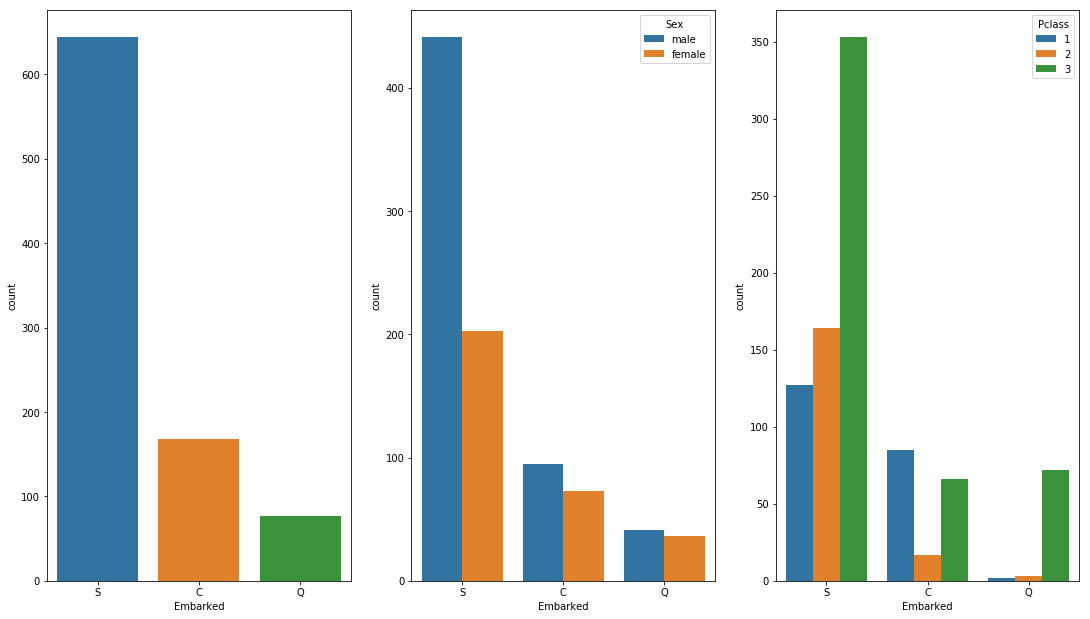

In [59]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3)
figure.set_size_inches(18.5, 10.5)
sns.countplot(x = df_1['Embarked'], ax = ax1)
sns.countplot(x = df_1['Embarked'], hue = df_1['Sex'],ax = ax2)
sns.countplot(x = df_1['Embarked'], hue = df_1['Pclass'],ax = ax3)
plt.show()

From those graphs, it is a safe bet to assign the 2 missing embarked rows to a "S", so lets go ahead and do this

The next major hurdle is that some of the data is objects or strings. For this analysis, we need
numerical data in order to run the NN. For sex, we can assign a 1 to a female and a 0 to a male
For embarked, we can do a similar change, but we will have three different numerical categories

Remember, we will not use the cabin data, and at this point

In [60]:
#I will use this label encoder function. It automatically assigns a numerical value to each category.
#Note that we do this for sex, embarked, and ticket.
#We also need to fill in the 1 nan value for the fare in the test set. Using a simple average will suffice for this
label_encoder = LabelEncoder()
df_1['Sex'] = label_encoder.fit_transform(df_1['Sex'])
test_data['Sex'] = label_encoder.fit_transform(test_data['Sex'])

df_1['Embarked'] = df_1['Embarked'].fillna("S")
df_1['Embarked'] = label_encoder.fit_transform(df_1['Embarked'])
test_data['Embarked'] = label_encoder.fit_transform(test_data['Embarked'])

df_1['Ticket'] = label_encoder.fit_transform(df_1['Ticket'])
test_data['Ticket'] = label_encoder.fit_transform(test_data['Ticket'])

test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mean())

In [61]:
df_1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,523,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,596,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,669,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,49,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,472,8.0500,NaN,2


Lets try to get some information from the Name feature
Lets first just look at the title, for example Mr. or miss, etc

In [62]:
def get_title(name):
    #Step 1: split the name on the first comma
    name_list = name.split(",")
    
    #Step 2: After splitting on the first comma, split on the period in the second element
    title = name_list[1].split(".")[0]
    
    #Step 3: There is a space that we need to remove
    title = title.split(" ")[1]
    
    #can do this in one line if need be
#     title = name.split(",")[1].split(".")[0].split(" ")[-1]
    
    #The majority of names are Mr Mrs Miss and Master, if not in that category, then will make it other
    if title not in ['Mr', "Mrs", 'Miss', "Master"]:
        title = 'Other'
    
    return title

df_1['Title'] = df_1['Name'].apply(get_title)
test_data['Title'] = test_data['Name'].apply(get_title)
print(set(df_1['Title'].values))
print(set(test_data['Title'].values))

{'Mr', 'Miss', 'Mrs', 'Master', 'Other'}
{'Mr', 'Miss', 'Mrs', 'Master', 'Other'}


Now that we have the title for each survivor, lets encode that to a numerical value just as we did
before. First, lets just get an idea of how the title distribution looks

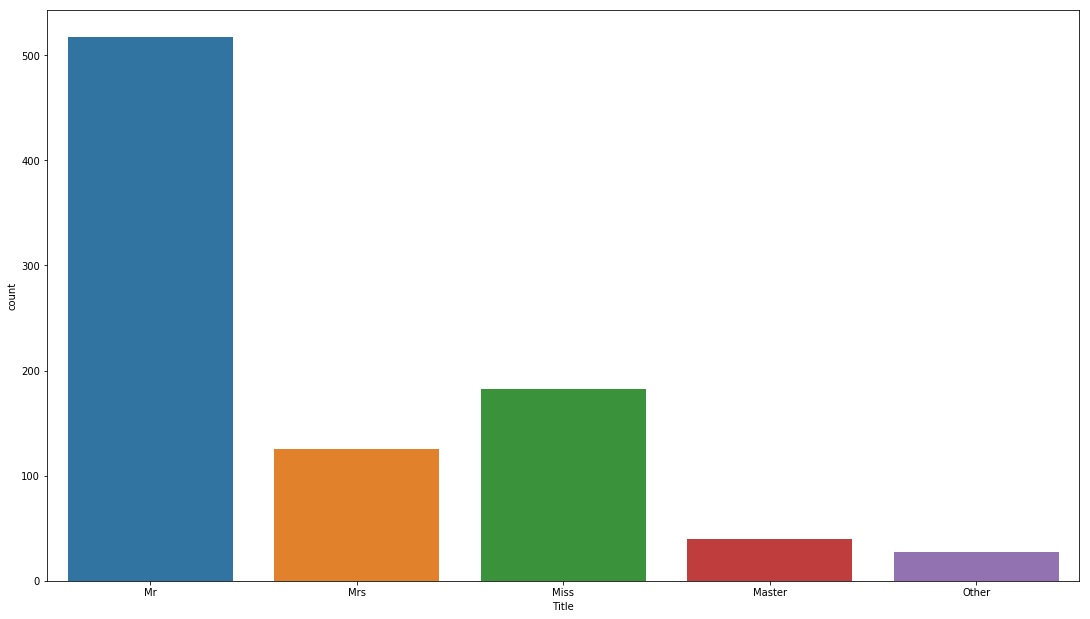

In [63]:
figure, ax1 = plt.subplots(1, 1)
figure.set_size_inches(18.5, 10.5)
sns.countplot(x = df_1['Title'], ax = ax1)
plt.show()

In [64]:
#Encode Titles
df_1['Title'] = label_encoder.fit_transform(df_1['Title'])
test_data['Title'] = label_encoder.fit_transform(test_data['Title'])

df_1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,523,7.2500,NaN,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,596,71.2833,C85,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,669,7.9250,NaN,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,49,53.1000,C123,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,472,8.0500,NaN,2,2


One last thing before we jump to the model
We should "normalize" the data in the sense we should bucket certain features to make things a bit more clear. 
we will do this with the age and Fare

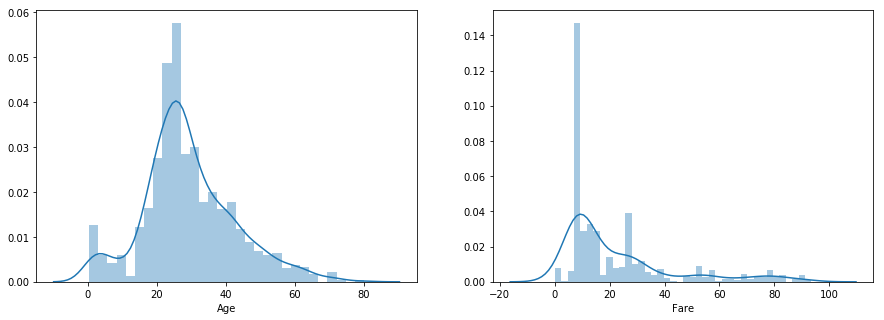

In [65]:
#In order to bucket, lets take a look at the distribution of fare and age
figure, (ax1, ax2) = plt.subplots(1, 2)
figure.set_size_inches(15, 5)
sns.distplot(df_1['Age'], ax = ax1,bins = 30)
sns.distplot(df_1[df_1['Fare'] <100]['Fare'], ax = ax2, bins = 40)
plt.show()

In [66]:
#Lets also take a look at the the stats
print(df_1['Age'].describe())
print(df_1['Fare'].describe())

count    891.000000
mean      29.318643
std       13.281103
min        0.420000
25%       21.750000
50%       26.507589
75%       36.000000
max       80.000000
Name: Age, dtype: float64
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [67]:
#For the fare, lets examine the quartiles
quartile_1 = np.percentile(df_1["Fare"],20)
quartile_2 = np.percentile(df_1["Fare"],40)
quartile_3 = np.percentile(df_1["Fare"],60)
quartile_4 = np.percentile(df_1["Fare"],80)
quartile_5 = np.percentile(df_1["Fare"],100)
quartiles = [quartile_1,quartile_2,quartile_3,quartile_4,quartile_5]
print(*quartiles)
print(df_1['Fare'].quantile([0.2,0.4,0.6,0.8,1]))

7.8542 10.5 21.6792 39.6875 512.3292
0.2      7.8542
0.4     10.5000
0.6     21.6792
0.8     39.6875
1.0    512.3292
Name: Fare, dtype: float64


In [68]:
#First make buckets for age
def bucket_age(age):
    if age <= 18:
        return 1
    elif age > 18 and age <= 22:
        return 2
    elif age > 22 and age <= 27:
        return 3
    elif age > 27 and age <= 33:
        return 4
    elif age > 33 and age <= 40:
        return 5
    else:
        return 6
    
    
def bucket_fare(fare):
    if fare <= quartiles[0]:
        return 0
    elif fare > quartiles[0] and fare <= quartiles[1]:
        return 1
    elif fare > quartiles[1] and fare <= quartiles[2]:
        return 2
    elif fare > quartiles[2] and fare <= quartiles[3]:
        return 3
    else:
        return 4
    
df_1['Age'] = df_1['Age'].apply(bucket_age)
df_1['Fare'] = df_1['Fare'].apply(bucket_age)

test_data['Age'] = test_data['Age'].apply(bucket_age)
test_data['Fare'] = test_data['Fare'].apply(bucket_age)

In [69]:
df_1['Fare'].value_counts()

1    502
6    176
3     89
4     61
2     33
5     30
Name: Fare, dtype: int64

Synthetic Features: If we were to use any synthetic features, I would place them here

In [70]:
#First Synthetic Feature: Age * Class
df_1['Age_Class'] = df_1.apply(lambda x: x['Age'] * x['Pclass'],axis = 1)
test_data['Age_Class'] = test_data.apply(lambda x: x['Age'] * x['Pclass'],axis = 1)

#Second Synthetic Feature: The number of relatives
df_1['Relatives'] = df_1.apply(lambda x: x['SibSp'] + x['Parch'], axis = 1)
test_data['Relatives'] = test_data.apply(lambda x: x['SibSp'] + x['Parch'], axis = 1)

In [71]:
# print({key: list(df_1['Relatives'].values).count(key) for key in list(df_1['Relatives'].values)})

Now that we have all of our features, lets get the data and build and train our model

In [80]:
#Split the data into features and labels
df_2 = df_1.copy()
labels = df_2['Survived']

features = ['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Age_Class', 'Relatives'] #These are the features that will be used in the model
data_for_model = df_2[features]
num_features = len(data_for_model.columns)
print("The number of features the model will be evaluating is {}".format(num_features))

The number of features the model will be evaluating is 7


In [81]:
data_for_model.head()

,Pclass,Sex,Age,Fare,Title,Age_Class,Relatives
0,3,1,2,1,2,6,1
1,1,0,5,6,3,5,1
2,3,0,3,1,1,9,0
3,1,0,5,6,3,5,1
4,3,1,5,1,2,15,0


Model Building Using Keras:

Let us know jump into building our model. Let's build a simple neural net that uses relu as the activation functions and softmax for the activation function of the final layer. My initial setup has 2 hidden layers

In [111]:
model = tf.keras.Sequential()
model.add(layers.Dense(70, input_shape=(num_features,),activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(70, activation = 'relu'))
model.add(layers.Dense(70, activation = 'relu'))
##Final layer
model.add(layers.Dense(2,activation = 'softmax'))
#need 2 output factors because we will use categorical cross entropy

In [112]:
#After testing, the adam optimizer seems to be producing the highest quality results
model.compile(optimizer= tf.train.AdamOptimizer() ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 70)                560       
_________________________________________________________________
dropout_8 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_29 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 142       
Total params: 10,642
Trainable params: 10,642
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
#Split data into test and train: Note using very small test set because already there is not a lot of
#data to work with
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_for_model, labels, test_size=0)
#Need to convert to float for run purposes
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)
print(x_train.shape,y_train.shape)

(891, 7) (891,)


In [115]:
#Need to convert to float for run purposes
x_train = x_train.astype(np.float64)
print(x_train.info())
x_train.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 855 to 859
Data columns (total 7 columns):
Pclass       891 non-null float64
Sex          891 non-null float64
Age          891 non-null float64
Fare         891 non-null float64
Title        891 non-null float64
Age_Class    891 non-null float64
Relatives    891 non-null float64
dtypes: float64(7)
memory usage: 55.7 KB
None


,Pclass,Sex,Age,Fare,Title,Age_Class,Relatives
855,3.0,0.0,1.0,1.0,3.0,3.0,1.0
470,3.0,1.0,3.0,1.0,2.0,9.0,0.0
386,3.0,1.0,1.0,6.0,0.0,3.0,7.0
434,1.0,1.0,6.0,6.0,2.0,6.0,1.0
304,3.0,1.0,3.0,1.0,2.0,9.0,0.0


Let us know train the data. First we need to transform the labels into the right format using the to_categorical funtion 

In [116]:
#This is critically important. It ensures the data is the right size moving forward
y_train = tf.keras.utils.to_categorical(y_train)

In [117]:
model_history = model.fit(x_train.values,y_train, epochs = 500, batch_size=20)

#N/81 means batch N out of 81 total batches. Total batches = total number data points / batch_size

Epoch 1/500
891/891 [==============================] - 1s 931us/step - loss: 0.6336 - acc: 0.6453
Epoch 2/500
891/891 [==============================] - 0s 144us/step - loss: 0.5789 - acc: 0.7160
Epoch 3/500
891/891 [==============================] - 0s 145us/step - loss: 0.5367 - acc: 0.7340
Epoch 4/500
891/891 [==============================] - 0s 141us/step - loss: 0.5192 - acc: 0.7464
Epoch 5/500
891/891 [==============================] - 0s 148us/step - loss: 0.4946 - acc: 0.7710
Epoch 6/500
891/891 [==============================] - 0s 143us/step - loss: 0.4825 - acc: 0.7789
Epoch 7/500
891/891 [==============================] - 0s 146us/step - loss: 0.4660 - acc: 0.7722
Epoch 8/500
891/891 [==============================] - 0s 150us/step - loss: 0.4729 - acc: 0.7710
Epoch 9/500
891/891 [==============================] - 0s 139us/step - loss: 0.4575 - acc: 0.7890
Epoch 10/500
891/891 [==============================] - 0s 141us/step - loss: 0.4478 - acc: 0.7957
Epoch 11/500
891/89

891/891 [==============================] - 0s 225us/step - loss: 0.3275 - acc: 0.8631
Epoch 165/500
891/891 [==============================] - 0s 259us/step - loss: 0.3437 - acc: 0.8608
Epoch 166/500
891/891 [==============================] - 0s 113us/step - loss: 0.3374 - acc: 0.8563
Epoch 167/500
891/891 [==============================] - 0s 110us/step - loss: 0.3448 - acc: 0.8519
Epoch 168/500
891/891 [==============================] - 0s 112us/step - loss: 0.3325 - acc: 0.8620
Epoch 169/500
891/891 [==============================] - 0s 107us/step - loss: 0.3435 - acc: 0.8541
Epoch 170/500
891/891 [==============================] - 0s 116us/step - loss: 0.3551 - acc: 0.8496
Epoch 171/500
891/891 [==============================] - 0s 112us/step - loss: 0.3412 - acc: 0.8586
Epoch 172/500
891/891 [==============================] - 0s 153us/step - loss: 0.3340 - acc: 0.8541
Epoch 173/500
891/891 [==============================] - 0s 111us/step - loss: 0.3303 - acc: 0.8586
Epoch 174/500


891/891 [==============================] - 0s 111us/step - loss: 0.3228 - acc: 0.8608
Epoch 246/500
891/891 [==============================] - 0s 144us/step - loss: 0.3254 - acc: 0.8664
Epoch 247/500
891/891 [==============================] - 0s 113us/step - loss: 0.3250 - acc: 0.8642
Epoch 248/500
891/891 [==============================] - 0s 113us/step - loss: 0.3246 - acc: 0.8653
Epoch 249/500
891/891 [==============================] - 0s 111us/step - loss: 0.3317 - acc: 0.8586
Epoch 250/500
891/891 [==============================] - 0s 127us/step - loss: 0.3342 - acc: 0.8608
Epoch 251/500
891/891 [==============================] - 0s 127us/step - loss: 0.3212 - acc: 0.8664
Epoch 252/500
891/891 [==============================] - 0s 117us/step - loss: 0.3231 - acc: 0.8698
Epoch 253/500
891/891 [==============================] - 0s 118us/step - loss: 0.3329 - acc: 0.8575
Epoch 254/500
891/891 [==============================] - 0s 114us/step - loss: 0.3249 - acc: 0.8597
Epoch 255/500


891/891 [==============================] - 0s 123us/step - loss: 0.3107 - acc: 0.8721
Epoch 408/500
891/891 [==============================] - 0s 115us/step - loss: 0.3095 - acc: 0.8687
Epoch 409/500
891/891 [==============================] - 0s 159us/step - loss: 0.3132 - acc: 0.8676
Epoch 410/500
891/891 [==============================] - 0s 114us/step - loss: 0.3034 - acc: 0.8743
Epoch 411/500
891/891 [==============================] - 0s 124us/step - loss: 0.3061 - acc: 0.8732
Epoch 412/500
891/891 [==============================] - 0s 127us/step - loss: 0.3012 - acc: 0.8810
Epoch 413/500
891/891 [==============================] - 0s 110us/step - loss: 0.3060 - acc: 0.8687
Epoch 414/500
891/891 [==============================] - 0s 125us/step - loss: 0.3195 - acc: 0.8642
Epoch 415/500
891/891 [==============================] - 0s 130us/step - loss: 0.3122 - acc: 0.8754
Epoch 416/500
891/891 [==============================] - 0s 113us/step - loss: 0.3185 - acc: 0.8698
Epoch 417/500


891/891 [==============================] - 0s 115us/step - loss: 0.2995 - acc: 0.8777
Epoch 490/500
891/891 [==============================] - 0s 113us/step - loss: 0.2973 - acc: 0.8732
Epoch 491/500
891/891 [==============================] - 0s 108us/step - loss: 0.2931 - acc: 0.8777
Epoch 492/500
891/891 [==============================] - 0s 163us/step - loss: 0.3014 - acc: 0.8765
Epoch 493/500
891/891 [==============================] - 0s 173us/step - loss: 0.2974 - acc: 0.8732
Epoch 494/500
891/891 [==============================] - 0s 116us/step - loss: 0.3116 - acc: 0.8709
Epoch 495/500
891/891 [==============================] - 0s 115us/step - loss: 0.3035 - acc: 0.8777
Epoch 496/500
891/891 [==============================] - 0s 110us/step - loss: 0.3034 - acc: 0.8698
Epoch 497/500
891/891 [==============================] - 0s 112us/step - loss: 0.3074 - acc: 0.8743
Epoch 498/500
891/891 [==============================] - 0s 110us/step - loss: 0.3007 - acc: 0.8754
Epoch 499/500


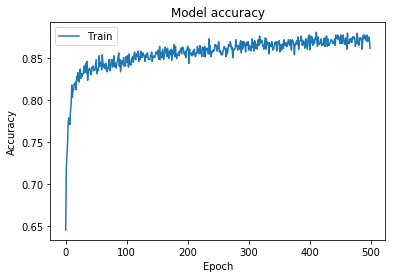

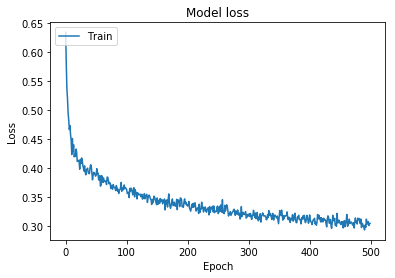

In [118]:
#Lets look at some visuals from our model
# Plot training & validation accuracy values
plt.plot(model_history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

After running the model, let's check the accuracy that we are obtaining on the training data
Remember, we want this to be high, but we always need to consider overfitting!

In [110]:
y_test = tf.keras.utils.to_categorical(y_test)
loss_and_metrics = model.evaluate(x_test, y_test)
print("Accuracy of %.2f" %loss_and_metrics[-1])

90/90 [==============================] - 0s 4ms/step
Accuracy of 0.80


Now let's run our final model on the test data and produce our results that will be submitted
to the competition

In [119]:
test_data_for_model = test_data[features]
test_data_for_model = test_data_for_model.astype(np.float64)
test_data_for_model.head()

,Pclass,Sex,Age,Fare,Title,Age_Class,Relatives
0,3.0,1.0,5.0,1.0,2.0,15.0,0.0
1,3.0,0.0,6.0,1.0,3.0,18.0,1.0
2,2.0,1.0,6.0,1.0,2.0,12.0,0.0
3,3.0,1.0,3.0,1.0,2.0,9.0,0.0
4,3.0,0.0,2.0,1.0,3.0,6.0,2.0


In [120]:
results = model.predict_classes(test_data_for_model)

In [121]:
titanic_submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": results})
titanic_submission.to_csv("Outputs/titanic_submission_4.csv",index = False)

After submitting this to the Kaggle website, the model received an accuracy of 0.76076

Areas for Improvement:
1. Look at sibling and parent relationship
2. Can get a better understanding of who survived and get new features such as fare per person